In [1]:
import os
import pickle
from itertools import product
from tqdm import tqdm

import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, f1_score, accuracy_score

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'serif'

In [2]:
class DataLoader:
    '''The following class will be used to load the data and apply few initial filtering/preprocessing steps'''
    @classmethod
    def load(cls, asset: str,
             sampling: str = '1H',
             year_start: int = 2000,
             year_end: int = None):
        if os.path.exists(f'{asset}.csv'):
            data = pd.read_csv(f'{asset}.csv', header=None)
        else:
            raise FileNotFoundError('{asset}.csv was not found!')
        data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        data.iloc[:, 1:-1] /= 10e3
        data['Date'] = pd.to_datetime(data['Date'])
        if year_end is None:
            year_end = data['Date'].dt.year.unique()[-1]
        data = data[(data['Date'].dt.year >= year_start) & (data['Date'].dt.year <= year_end)]
        data.reset_index(inplace=True, drop=True)
        if sampling != '1H':
            data = cls._resample(data, sampling)
        return data

    @staticmethod
    def _resample(data: pd.DataFrame, sampling):
        data.set_index('Date', inplace=True)
        data = data.resample(sampling).agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last'})
        data.dropna(inplace=True)
        data.reset_index(inplace=True)
        return data

Loading hourly IBM stock data since 2000, which is then resampled into 3 hour candles. The data is sourced from https://github.com/QuantConnect/Lean/tree/master/Data/equity which was provided by QuantQuote.

In [3]:
df = DataLoader.load('ibm', sampling='3H', year_start=2000)

FileNotFoundError: {asset}.csv was not found!

In [ ]:
df.head(5)

#### Exploratory Data Analysis

Let's first visualise our financial time series to get an idea of stock's behavior.

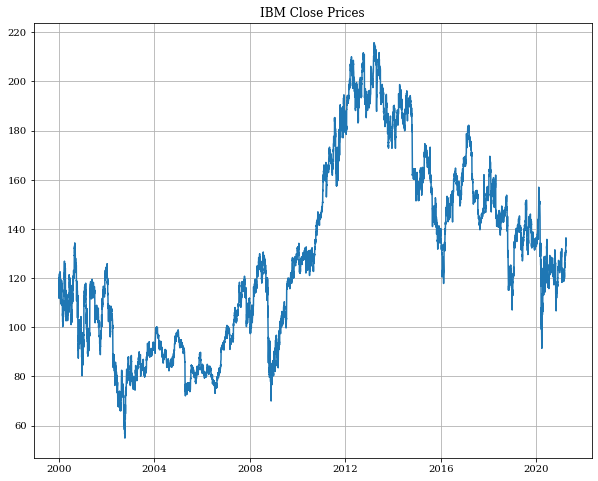

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(df['Date'], df['Close'])
plt.title('IBM Close Prices')
plt.grid()
plt.show()

Quite a few linear models assume the stationarity in time series as they account for oscillations but not for trends. Usually raw financial time series are non-stationary. Let's test that using Dickey-Fuller test for stationarity.

In [12]:
temp_df = []
for year in df['Date'].dt.year.unique()[::3]:
    res = adfuller(df[df['Date'].dt.year == year]['Close'].values)
    temp_df.append({'year': year, 'p-value': round(res[1], 4)})
pd.DataFrame(temp_df)

,year,p-value
0,2000,0.3422
1,2003,0.3632
2,2006,0.9883
3,2009,0.7372
4,2012,0.0687
5,2015,0.8674
6,2018,0.8959
7,2021,0.5511


As we can see for each year p-value is above the significance level, therefore our time series are non-statinory. One of the most common ways is to take logarithmic returns of our time series which will convert the original price series from a non-stationary series to a potentially stationary one.

In [13]:
df['ln_Close'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)

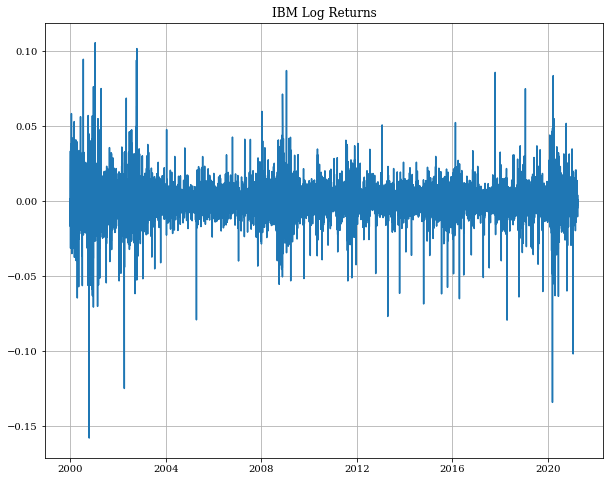

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(df['Date'], df['ln_Close'])
plt.title('IBM Log Returns')
plt.grid()
plt.show()

To make sure let's rerun Dickey-Fuller test to see that p-values are less than the significance level now.

In [15]:
temp_df = []
for year in df['Date'].dt.year.unique()[::3]:
    res = adfuller(df[df['Date'].dt.year == year]['ln_Close'].values)
    temp_df.append({'year': year, 'p-value': round(res[1], 4)})
pd.DataFrame(temp_df)

,year,p-value
0,2000,0.0
1,2003,0.0
2,2006,0.0
3,2009,0.0
4,2012,0.0
5,2015,0.0
6,2018,0.0
7,2021,0.0


#### Building Baseline Predictions

Since we are going to use ARIMA as our baseline model we'll need to estimate parameters `p` and `q` which are auto-regressiona and moving average parameters respectively. We don't need to estimate integration parameter `d` as we've already taken care of it by taking log returns.

To get an idea of range of values that `p` and `q` can take let's plot the following correlograms which are simply the plots of the autocorrelation function for sequential values of lag. The main usage of correlograms is to detect any autocorrelation subsequent to the removal of any deterministic trends or seasonality effects.

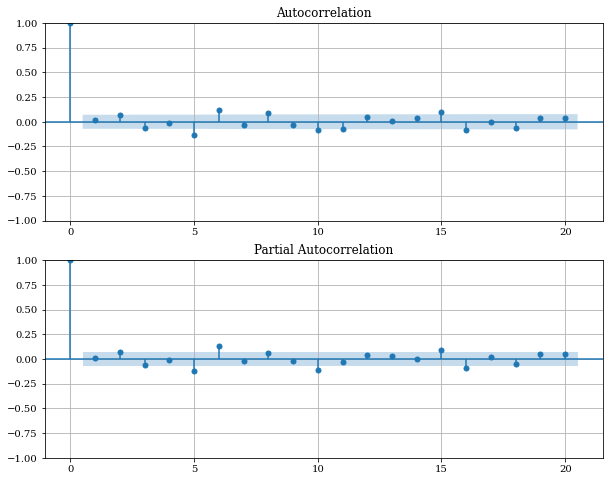

In [16]:
plt.figure(figsize=(10, 8))
ax = plt.subplot(211)
plot_acf(df[df['Date'].dt.year == 2020]['ln_Close'], lags=20, ax=ax)
plt.grid()
ax = plt.subplot(212)
plot_pacf(df[df['Date'].dt.year == 2020]['ln_Close'], lags=20, ax=ax, method='ywm')
plt.grid()
plt.show()

As we can see there there are significant peaks at lags 2, 3 and 5. Therefore during our backtest let's try to fit our ARIMA model on the range of parameters from 0 to 5.

In [17]:
# for ignoring warnings while fitting ARIMA
import warnings
warnings.filterwarnings('ignore')

Backtester was meant to be built to imitate the real-life trading, meaning that we have a sliding window where we fit our strategy and make one step ahead prediction. Therefore we iterate over our data using the window to avoid any forward looking bias. Refit window is used to reduce the time of backtesting as optimizing ARIMA `(p,d,q)` parameters on each step is very time expensive, therefore we will only do it once in a while and use these stored parameters until the next refit time comes.

The backtesting class also implements a `summary` method which currently plots predictions again real values and calculates different metrics. Also will need to add the PnL plot to this method later on.

In [18]:
class BackTester:
    def __init__(self, 
                 data: pd.DataFrame, 
                 strategy,
                 window: int, 
                 refit_window: int):
        '''
            data: data for backtesting
            strategy: strategy class to backtest
            window: time window on which to fit the strategy
            refit_window: how often we refit the strategy
        '''
        self.data = data
        self.strategy = strategy
        self.window, self.refit_window = window, refit_window
    
    def run(self):
        '''main method to iterate over the data and store predictions'''
        predictions = [np.nan] * self.window
        for i, idx in enumerate(tqdm(range(self.data.shape[0] - self.window))):
            # slice the window
            X = self.data.iloc[idx:idx + self.window, :]
            # check if it is time to refit
            if i % self.refit_window == 0:
                self.strategy.fit(X)
            # make one step prediction
            pred = self.strategy.predict(X)
            predictions.append(pred)

        self.data['ln_Pred'] = predictions
        
        # cache results
        with open(f'{self.strategy.__class__.__name__}_{self.window}_{self.refit_window}.pkl', 'wb') as f:
            pickle.dump(self.data, f)
    
    def summary(self, cache_path=None):
        if cache_path is not None:
            with open(cache_path, 'rb') as f:
                self.data = pickle.load(f)
        
        # transform the predictions from the log changes to the actual prices
        self.data['Pred_tmp'] = self.data['ln_Pred'].shift(-1)
        self.data['Pred_Close'] = np.exp(np.log(self.data['Close'] + self.data['Pred_tmp']))
        self.data['Pred_Close'] = self.data['Pred_Close'].shift(1)
        self.data.drop(['Pred_tmp'], axis=1, inplace=True)
        
        plt.figure(figsize=(10, 8))
        plt.plot(self.data['Date'], self.data['Close'], label='Close')
        plt.plot(self.data['Date'], self.data['Pred_Close'], linestyle='--', label='Prediction')
        plt.grid()
        plt.legend()
        plt.show()
        
        # run some regression metrics
        y_pred = self.data[~self.data['Pred_Close'].isna()]['Pred_Close']
        y_true = self.data[~self.data['Pred_Close'].isna()]['Close']
        print(f'MSE: {mean_squared_error(y_true, y_pred)}')
        print(f'MAE: {mean_absolute_error(y_true, y_pred)}')
        print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')
        
        # run some classification metrics (how accurate do we guess the sign of a change of price)
        y_pred = np.sign(self.data[~self.data['Pred_Close'].isna()]['ln_Pred'])
        y_true = np.sign(self.data[~self.data['Pred_Close'].isna()]['ln_Close'])
        # due to the nature of our data (only 2 decimal points) there are few occasions when close price is unchanged
        # applying a small tweak to make our target and prediction binary
        y_true[y_true == 0] = 1.0
        y_pred[y_pred == 0] = 1.0
        print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
        print(f'f1: {f1_score(y_true, y_pred)}')

In [19]:
class BaseStrategy:
    '''Abstract strategy class to implement fit and predict methods'''
    def fit(self, X):
        raise NotImplementedError
    
    def predict(self, X=None):
        raise NotImplementedError

class StrategyDummy(BaseStrategy):
    '''Dummy strategy which is just using the last value as a prediction'''
    def fit(self, X):
        pass
    
    def predict(self, X=None):
        return X['ln_Close'].values[-1]

class StrategyARIMA(BaseStrategy):
    '''ARIMA strategy class'''
    def __init__(self, max_p: int = 5, max_q: int = 5):
        super().__init__()
        self.max_p, self.max_q = max_p, max_q
        self.params = None
    
    def fit(self, X):
        '''Calculates ARIMA parameters by minimizing Akaike Information Criterion and stores the best combination'''
        xs = X['ln_Close'].values
        final_aic = np.inf
        parameters = list(product(range(5), range(5)))
        for param in parameters:
            if param[0] == param[1] == 0:
                continue
            try:
                model = ARIMA(xs, order=(param[0], 0, param[1])).fit()
            except ValueError:
                continue
            if model.aic < final_aic:
                final_aic = model.aic
                self.params = param
        
    def predict(self, X=None):
        '''Predicts the next value by fitting the ARIMA model to the latest available data
            with the set of the stored parameters'''
        xs = X['ln_Close'].values
        model = ARIMA(xs, order=(self.params[0], 0, self.params[1])).fit()
        pred = model.forecast(steps=1)[0]
        return pred

In [28]:
strategy = StrategyARIMA()

# let's use approximately 2 years of data for window and refit it annualy
backtester = BackTester(data=df,
                       strategy=strategy,
                       window=3*64,
                       refit_window=3*64)

# commenting it out as it takes around an hour and a half to run it
backtester.run()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 15794/15794 [32:14<00:00,  8.16it/s]


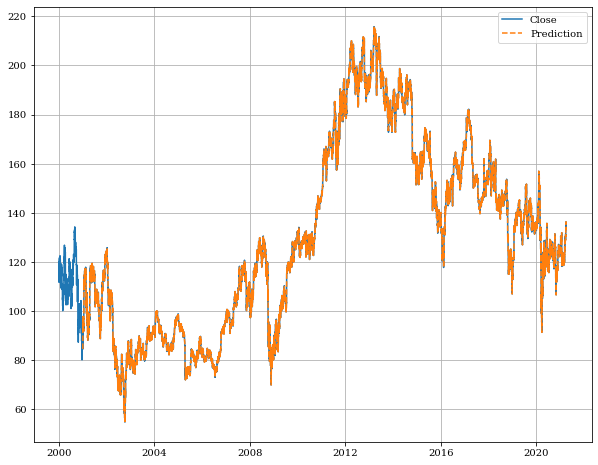

MSE: 1.2024440246439305
MAE: 0.6758880802113405
MAPE: 0.0055251722221116425
Accuracy: 0.5053184504267892
f1: 0.5123624595469256


In [26]:
# load summary from cache
backtester.summary(cache_path='StrategyARIMA_756_756.pkl')

As we can see MSE, MAE and MAPE show relatively good result. However, I believe for the trading purposes it makes more sense to look at the classification metrics, which will tell us how often we can predict where the price will turn (either positive or negative). As we can see the accuracy only comes around 50% which is not an impressive result.

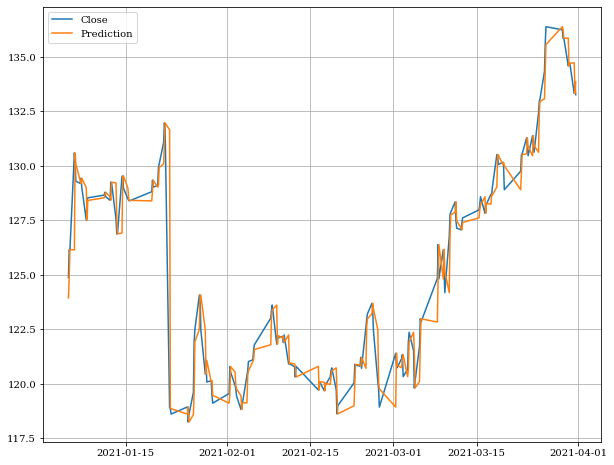

In [115]:
# taking a closer look at how our predictions look
plt.figure(figsize=(10, 8))
plt.plot(backtester.data['Date'].iloc[-180:], backtester.data['Close'].iloc[-180:], label='Close') 
plt.plot(backtester.data['Date'].iloc[-180:], backtester.data['Pred_Close'].iloc[-180:], label='Prediction')
plt.legend()
plt.grid()
plt.show()

Let's compare our ARIMA results with the Dummy strategy (the one that uses the last return as the prediction) and see if it actually does any better job in predicting.

100%|█████████████████████████████████████████████████████████████████████████| 14474/14474 [00:01<00:00, 12820.05it/s]


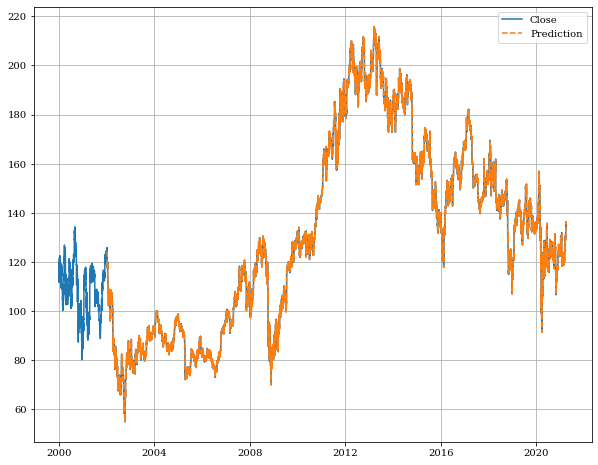

MSE: 1.1650508435036286
MAE: 0.6616212552867152
MAPE: 0.0053454574643774415
Accuracy: 0.4862512090645295
f1: 0.48942598187311176


In [161]:
strategy = StrategyDummy()

backtester = BackTester(data=df,
                       strategy=strategy,
                       window=3*252*2,
                       refit_window=3*252)
backtester.run()

backtester.summary()

Actually we can see that accuracy is a bit less for the Dummy strategy which is a good news.

#### Plan for the next weeks

1. Try to test different fitting windows for the ARIMA. Maybe a shorter window will work better.
2. Add GARCH to ARIMA model to try model volatility.
3. Add PnL plots to the BackTester class as this will be the ultimate metric to judge on.
4. Add more features for the ML models. Try to tune few ML models.